**What should I expect the data format to be?**

The data is images of wheat fields, with bounding boxes for each identified wheat head. Not all images include wheat heads / bounding boxes. The images were recorded in many locations around the world.

The CSV data is simple - the image ID matches up with the filename of a given image, and the width and height of the image are included, along with a bounding box (see below). There is a row in train.csv for each bounding box. Not all images have bounding boxes.

Most of the test set images are hidden. A small subset of test images has been included for your use in writing code.

**What am I predicting?**

You are attempting to predict bounding boxes around each wheat head in images that have them. If there are no wheat heads, you must predict no bounding boxes.

**Columns**

image_id - the unique image ID

width, height - the width and height of the images

bbox - a bounding box, formatted as a Python-style list of [xmin, ymin, width, height]
etc.

In [ ]:
import os
import time
import shutil
import random

import numpy as np
import pandas as pd

import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor, FasterRCNN
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone
from tqdm.notebook import tqdm

import albumentations

import cv2
import matplotlib.pyplot as plt
from matplotlib import patches
import seaborn as sns

In [ ]:
!pip install albumentations==0.4.6
import albumentations 
from albumentations.pytorch import ToTensorV2

In [ ]:
!wget --header="Host: storage.googleapis.com" --header="User-Agent: Mozilla/5.0 (X11; CrOS x86_64 13816.82.0) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/90.0.4430.218 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-US,en;q=0.9" --header="Referer: https://www.kaggle.com/" "https://storage.googleapis.com/kaggle-competitions-data/kaggle-v2/19989/1160143/bundle/archive.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1622642364&Signature=njlkUUiBAZFKZHDibooxXbxSNN83z3a5q%2BjyngH14%2BjRAP0RXjuceCYdVZun9M9s%2BmMcKcAlqtgdb%2Bsi3TnNwDMubtzKA5k8jN28840BYCawj88F6ps8mOMS8vRK9nCRCMIXgeUbind0S46EPTSiYu%2FH4xNmTphe7W45MeSzb97oLpSoMzSflYTnpQO1ofKrwKAqFQyFHvXnKiWlMGdkK4kLyGGkaKQmrRiELBXM7pYcff0ekgNuKOELZx2VnRDBe2418tI49A2I%2FJDz4eG4YFPFEjeBpBZXWr5emndjj0xkMmjQ94%2FYH9%2FIu1Wwd4mCQPTeEqWdIjrWCr3%2FnKwvYQ%3D%3D&response-content-disposition=attachment%3B+filename%3Dglobal-wheat-detection.zip" -c -O 'global-wheat-detection.zip'

--2021-05-30 17:28:46--  https://storage.googleapis.com/kaggle-competitions-data/kaggle-v2/19989/1160143/bundle/archive.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1622642364&Signature=njlkUUiBAZFKZHDibooxXbxSNN83z3a5q%2BjyngH14%2BjRAP0RXjuceCYdVZun9M9s%2BmMcKcAlqtgdb%2Bsi3TnNwDMubtzKA5k8jN28840BYCawj88F6ps8mOMS8vRK9nCRCMIXgeUbind0S46EPTSiYu%2FH4xNmTphe7W45MeSzb97oLpSoMzSflYTnpQO1ofKrwKAqFQyFHvXnKiWlMGdkK4kLyGGkaKQmrRiELBXM7pYcff0ekgNuKOELZx2VnRDBe2418tI49A2I%2FJDz4eG4YFPFEjeBpBZXWr5emndjj0xkMmjQ94%2FYH9%2FIu1Wwd4mCQPTeEqWdIjrWCr3%2FnKwvYQ%3D%3D&response-content-disposition=attachment%3B+filename%3Dglobal-wheat-detection.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.23.128, 74.125.203.128, 74.125.204.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.23.128|:443... connected.
HTTP request sent, awaiting response... 416 Requested range not satisfiable

    The file is already fully retrieved; nothing to d

In [ ]:
!unzip global-wheat-detection.zip

Archive:  global-wheat-detection.zip
replace sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: All
  inflating: sample_submission.csv   
  inflating: test/2fd875eaa.jpg      
  inflating: test/348a992bb.jpg      
  inflating: test/51b3e36ab.jpg      
  inflating: test/51f1be19e.jpg      
  inflating: test/53f253011.jpg      
  inflating: test/796707dd7.jpg      
  inflating: test/aac893a91.jpg      
  inflating: test/cb8d261a3.jpg      
  inflating: test/cc3532ff6.jpg      
  inflating: test/f5a1f0358.jpg      
  inflating: train.csv               
  inflating: train/00333207f.jpg     
  inflating: train/005b0d8bb.jpg     
  inflating: train/006a994f7.jpg     
  inflating: train/00764ad5d.jpg     
  inflating: train/00b5c6764.jpg     
  inflating: train/00b5fefed.jpg     
  inflating: train/00b70a919.jpg     
  inflating: train/00e903abe.jpg     
  inflating: train/00ea5e5ee.jpg     
  inflating: train/010b216d4.jpg     
  inflating: train/010c93b99.jpg     
  inflating: tra

In [ ]:
raw=pd.read_csv('/content/train.csv')

In [ ]:
raw

,image_id,width,height,bbox,source
0,b6ab77fd7,1024,1024,"[834.0, 222.0, 56.0, 36.0]",usask_1
1,b6ab77fd7,1024,1024,"[226.0, 548.0, 130.0, 58.0]",usask_1
2,b6ab77fd7,1024,1024,"[377.0, 504.0, 74.0, 160.0]",usask_1
3,b6ab77fd7,1024,1024,"[834.0, 95.0, 109.0, 107.0]",usask_1
4,b6ab77fd7,1024,1024,"[26.0, 144.0, 124.0, 117.0]",usask_1
...,...,...,...,...,...
147788,5e0747034,1024,1024,"[64.0, 619.0, 84.0, 95.0]",arvalis_2
147789,5e0747034,1024,1024,"[292.0, 549.0, 107.0, 82.0]",arvalis_2
147790,5e0747034,1024,1024,"[134.0, 228.0, 141.0, 71.0]",arvalis_2
147791,5e0747034,1024,1024,"[430.0, 13.0, 184.0, 79.0]",arvalis_2


observations:

1)image_id - the unique image ID

2) width, height - the width and height of the images
bbox - a bounding box, formatted as a Python-style list of [xmin, ymin, width, height]
etc.

In [ ]:
raw['image_id'].value_counts()

35b935b6c    116
f1794c924    108
f79336a8e    104
134d4a01c    101
b70c20580     97
            ... 
79c8a1627      1
ce4124be0      1
6a62af644      1
4e6c05213      1
86296fc32      1
Name: image_id, Length: 3373, dtype: int64

In [ ]:
raw.groupby('image_id')['bbox'].count().agg(['min','max','mean'])

min       1.000000
max     116.000000
mean     43.816484
Name: bbox, dtype: float64

maximum bbox in image is 116
minimum bbox in image is 1
mean bbox in image is 43

In [ ]:
#unique image ids
len(set(raw['image_id']))

3373

In [ ]:
raw['source'].value_counts()

ethz_1       51489
arvalis_1    45716
rres_1       20236
arvalis_3    16665
usask_1       5807
arvalis_2     4179
inrae_1       3701
Name: source, dtype: int64

In [ ]:
import seaborn as sns

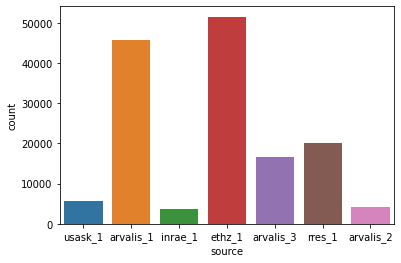

In [ ]:
sns.countplot(x='source',data=raw)

In [ ]:
#setting path directories
DATA_DIR  = '/content/train/'
TEST_DIR  = '/content/test/'
train_df_path = '/content/train.csv'
test_df_path = '/content/sample_submission.csv'
List_Data_dir = os.listdir(DATA_DIR)

In [ ]:
import os
no_of_training_images=os.listdir(DATA_DIR)
len(no_of_training_images)


3422

In [ ]:
no_of_testing_images=os.listdir(TEST_DIR)
len(no_of_testing_images)

10

In [ ]:
raw

,image_id,width,height,bbox,source
0,b6ab77fd7,1024,1024,"[834.0, 222.0, 56.0, 36.0]",usask_1
1,b6ab77fd7,1024,1024,"[226.0, 548.0, 130.0, 58.0]",usask_1
2,b6ab77fd7,1024,1024,"[377.0, 504.0, 74.0, 160.0]",usask_1
3,b6ab77fd7,1024,1024,"[834.0, 95.0, 109.0, 107.0]",usask_1
4,b6ab77fd7,1024,1024,"[26.0, 144.0, 124.0, 117.0]",usask_1
...,...,...,...,...,...
147788,5e0747034,1024,1024,"[64.0, 619.0, 84.0, 95.0]",arvalis_2
147789,5e0747034,1024,1024,"[292.0, 549.0, 107.0, 82.0]",arvalis_2
147790,5e0747034,1024,1024,"[134.0, 228.0, 141.0, 71.0]",arvalis_2
147791,5e0747034,1024,1024,"[430.0, 13.0, 184.0, 79.0]",arvalis_2


plotting images without bounday boxes

In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (24, 24))
ax = ax.flatten()
img_path = os.path.join(DATA_DIR, 'b6ab77fd7' + '.jpg')
img_path2 = os.path.join(DATA_DIR, '5e0747034' + '.jpg')

image = cv2.imread(img_path, cv2.IMREAD_COLOR)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
image /= 255.0
    
ax[0].set_title('Image')
ax[0].imshow(image)
    
image2 = cv2.imread(img_path2, cv2.IMREAD_COLOR)
image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB).astype(np.float32)
image2 /= 255.0

ax[1].set_title('Image')
ax[1].imshow(image2)

plt.show()

Output hidden; open in https://colab.research.google.com to view.

converting xmin,ymin to xmax ,ymax format:- xmin,ymin,xmax,ymax which is acceptable for your model

In [ ]:

raw[['xmin','ymin','w','h']] = pd.DataFrame(raw.bbox.str.strip('[]').str.split(',').tolist()).astype(float)
raw['xmax'], raw['ymax'], raw['area'] = raw['xmin'] + raw['w'], raw['ymin'] + raw['h'], raw['w'] * raw['h']
raw.drop(['bbox'], axis=1, inplace= True)
raw

,image_id,width,height,source,xmin,ymin,w,h,xmax,ymax,area
0,b6ab77fd7,1024,1024,usask_1,834.0,222.0,56.0,36.0,890.0,258.0,2016.0
1,b6ab77fd7,1024,1024,usask_1,226.0,548.0,130.0,58.0,356.0,606.0,7540.0
2,b6ab77fd7,1024,1024,usask_1,377.0,504.0,74.0,160.0,451.0,664.0,11840.0
3,b6ab77fd7,1024,1024,usask_1,834.0,95.0,109.0,107.0,943.0,202.0,11663.0
4,b6ab77fd7,1024,1024,usask_1,26.0,144.0,124.0,117.0,150.0,261.0,14508.0
...,...,...,...,...,...,...,...,...,...,...,...
147788,5e0747034,1024,1024,arvalis_2,64.0,619.0,84.0,95.0,148.0,714.0,7980.0
147789,5e0747034,1024,1024,arvalis_2,292.0,549.0,107.0,82.0,399.0,631.0,8774.0
147790,5e0747034,1024,1024,arvalis_2,134.0,228.0,141.0,71.0,275.0,299.0,10011.0
147791,5e0747034,1024,1024,arvalis_2,430.0,13.0,184.0,79.0,614.0,92.0,14536.0


plotting images with boundary boxes

In [ ]:
def show_image(image_id):
    
    fig, ax = plt.subplots(1, 2, figsize = (24, 24))
    ax = ax.flatten()
    
    bbox = raw[raw['image_id'] == image_id ]
    img_path = os.path.join(DATA_DIR, image_id + '.jpg')
    
    image = cv2.imread(img_path, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
    image /= 255.0
    image2 = image
    
    ax[0].set_title('Original Image')
    ax[0].imshow(image)
    
    for idx, row in bbox.iterrows():
        x1 = row['xmin']
        y1 = row['ymin']
        x2 = row['xmax']
        y2 = row['ymax']
        label = row['source']
        
        cv2.rectangle(image2, (int(x1),int(y1)), (int(x2),int(y2)), (255,255,255), 2)
        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(image2, label, (int(x1),int(y1-10)), font, 1, (255,255,255), 2)
    
    ax[1].set_title('Image with Bondary Box')
    ax[1].imshow(image2)

    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


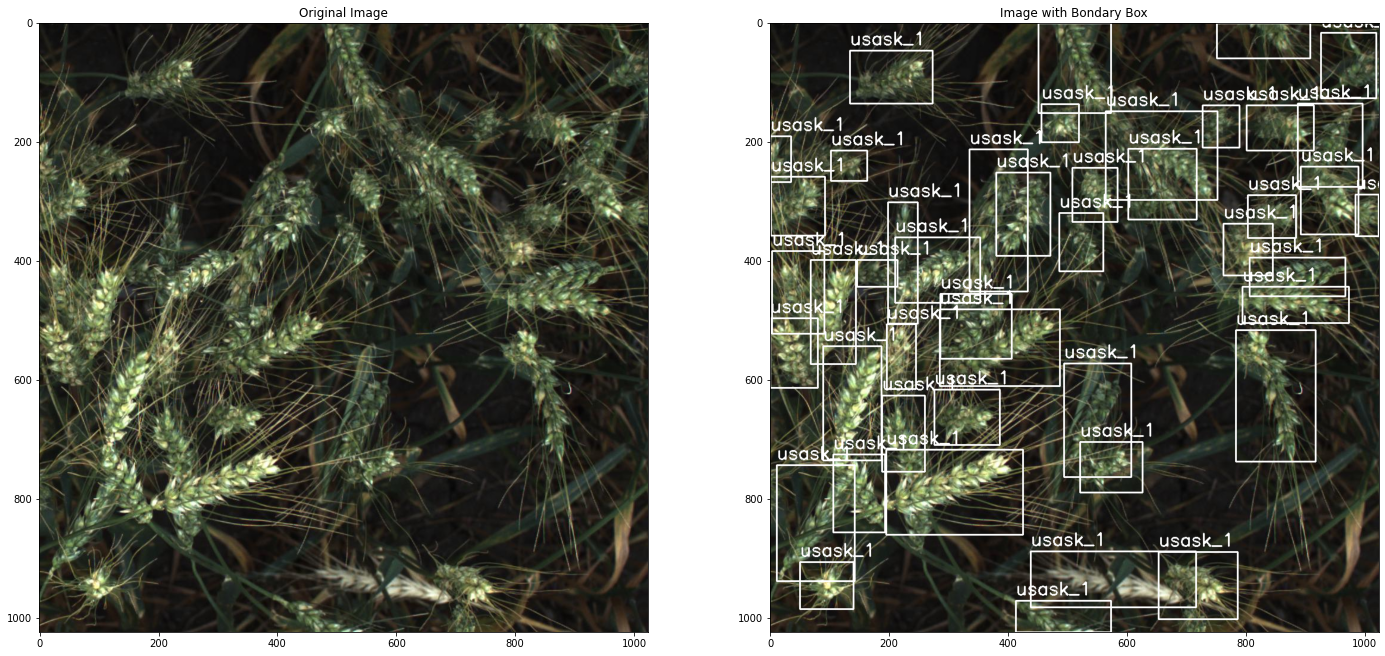

In [ ]:
show_image(raw.image_id.unique()[91])

In [ ]:
def get_bboxes(bboxes, col, bbox_format = 'pascal_voc', color='white'):
    for i in range(len(bboxes)):
        x_min = bboxes[i][0]
        y_min = bboxes[i][1]
        x_max = bboxes[i][2]
        y_max = bboxes[i][3]
        width = x_max - x_min
        height = y_max - y_min
        rect = patches.Rectangle((x_min, y_min), 
                                 width, height, 
                                 linewidth=2, 
                                 edgecolor=color, 
                                 facecolor='none')
        col.add_patch(rect)

data argumentation 

In [ ]:
def augmented_images(image, augment):
    
    fig, ax = plt.subplots(1, 2, figsize = (24, 24))
    ax = ax.flatten()
    
    image_data = raw[raw['image_id'] == image]
    bbox = image_data[['xmin', 'ymin', 'xmax', 'ymax']].astype(np.int32).values
    labels = np.ones((len(bbox), ))

    image = cv2.imread(os.path.join(DATA_DIR + '/{}.jpg').format(image), cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
    image /= 255.0
    
    get_bboxes(bbox, ax[0], color='white')
    
    ax[0].set_title('Original Image with Bounding Boxes')
    ax[0].imshow(image)
    
    aug = albumentations.Compose([augment], 
                         bbox_params={'format': 'pascal_voc', 'label_fields':['labels']})

    
    aug_result = aug(image=image, bboxes=bbox, labels=labels)

    aug_image = aug_result['image']
    get_bboxes(aug_result['bboxes'], ax[1], color='red')
    
    ax[1].set_title('Augmented Image with Bounding Boxes')
    ax[1].imshow(aug_image)
    
    plt.show()


In [ ]:
augmented_images(raw.image_id.unique()[1230], albumentations.HorizontalFlip(p=1))

Output hidden; open in https://colab.research.google.com to view.

# Create Dataset
The dataset should inherit from the standard torch.utils.data.Dataset class [link text](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset), and implement __len__ and __getitem__.

The only specificity that we require is that the dataset __getitem__ should return:

image: a numpy.ndarray image

target: a dict containing the following fields

1)boxes (FloatTensor[N, 4]): the coordinates of the N bounding boxes in [x0, y0, x1, y1] format, ranging from 0 to W and 0 to H

2) labels (Int64Tensor[N]): the label for each bounding box

3) image_id (Int64Tensor[1]): an image identifier. It should be unique between all the images in the dataset, and is used during evaluation

4) area (Tensor[N]): The area of the bounding box. This is used during evaluation with the COCO metric, to separate the metric scores between small, medium and large boxes.

5) iscrowd (UInt8Tensor[N]): instances with iscrowd=True will be ignored during evaluation.

In [ ]:
class wheatdataset_train(Dataset):
       
    def __init__(self, dataframe, data_dir, transforms=None):
        super().__init__()
        self.df = dataframe 
        self.image_list = list(self.df['image_id'].unique())
        self.image_dir = data_dir
        self.transforms = transforms
    
    def __len__(self):
        return len(self.image_list)
        
    def __getitem__(self, idx):
        
        image_id = self.image_list[idx]
        image_data = self.df.loc[self.df['image_id'] == image_id]
        boxes = torch.as_tensor(np.array(image_data[['xmin','ymin','xmax','ymax']]), 
                                dtype=torch.float32)
        area = torch.tensor(np.array(image_data['area']), dtype=torch.int64) 
        labels = torch.ones((image_data.shape[0],), dtype=torch.int64)
        iscrowd = torch.zeros((image_data.shape[0],), dtype=torch.uint8)
         
        target = {}
        target['boxes'] = boxes
        target['area'] = area
        target['labels'] = labels
        target['iscrowd'] = iscrowd
        
        image = cv2.imread((self.image_dir + '/' + image_id + '.jpg'), cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        
        if self.transforms:
            
            image_transforms = {
                                'image': image,
                                'bboxes': target['boxes'],
                                'labels': labels
                                 }
            
            image_transforms = self.transforms(**image_transforms)
            image = image_transforms['image']
            
            target['boxes'] = torch.as_tensor(image_transforms['bboxes'], dtype=torch.float32)
                 
        return image, target

In [ ]:
def get_train_transform():
    return albumentations.Compose([
        #albumentations.Resize(p=1, height=512, width=512),
        albumentations.ToGray(p=0.5),
        albumentations.Flip(p=0.5),
        albumentations.RandomBrightnessContrast(p=0.5),
        albumentations.Cutout(num_holes= random.randint(10, 20), max_h_size= 64, max_w_size =64, p = 0.40),
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})


def get_test_transform():
    return albumentations.Compose([
        ToTensorV2(p=1.0)
    ])


def collate_fn(batch):
    return tuple(zip(*batch))

**Create DataLoader**

In [ ]:
train_data = wheatdataset_train(raw, DATA_DIR, get_train_transform())
train_dataloader = DataLoader(train_data, batch_size=16,shuffle=True, num_workers=4,collate_fn=collate_fn)

In [ ]:
len(train_data)

3373

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
torch.cuda.empty_cache()
print(device)

cuda


importing model

In [ ]:
def train_model():
    
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    num_classes = 2  # wheat or not(background)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

**training model**

In [ ]:
def train(data_loader, epoch):
        
    model = train_model()
    model.train()
    model.to(device)
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
    model.parameters


    total_train_loss = []
    itr = 1

    for epoch in tqdm(range(epoch)):
        
        print(f'Epoch :{epoch + 1}')
        start_time = time.time()
        train_loss = []
        
        for images, targets in tqdm(data_loader):
            
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            loss_dict = model(images, targets)

            losses = sum(loss for loss in loss_dict.values())
            
            loss_value = losses.item()
            
            train_loss.append(losses.item())
            optimizer.zero_grad()
            losses.backward()
            optimizer.step()
            
            if itr % 50 == 0:
                print(f"Iteration #{itr} loss: {loss_value:.4f}")

            itr += 1
    
        
        epoch_train_loss = np.mean(train_loss)
        total_train_loss.append(epoch_train_loss)
        print(f'Epoch train loss is {epoch_train_loss:.4f}')
        time_elapsed = time.time() - start_time
        print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

    torch.save(model.state_dict(), 'resnet50_GWD.pth')




In [ ]:
train(train_dataloader, 5)

Epoch :1


Iteration #50 loss: 1.0603
Iteration #100 loss: 0.9929
Iteration #150 loss: 1.0013
Iteration #200 loss: 0.9254

Epoch train loss is 1.0482
5m 43s
Epoch :2


Iteration #250 loss: 0.8719
Iteration #300 loss: 0.8800
Iteration #350 loss: 0.8614
Iteration #400 loss: 0.9089

Epoch train loss is 0.8911
5m 43s
Epoch :3


Iteration #450 loss: 0.9287
Iteration #500 loss: 0.9445
Iteration #550 loss: 0.8955
Iteration #600 loss: 0.8846

Epoch train loss is 0.8556
5m 43s
Epoch :4


Iteration #650 loss: 0.7992
Iteration #700 loss: 0.8167
Iteration #750 loss: 0.7245
Iteration #800 loss: 0.8506

Epoch train loss is 0.8305
5m 43s
Epoch :5


Iteration #850 loss: 0.8939
Iteration #900 loss: 0.7715
Iteration #950 loss: 0.8024
Iteration #1000 loss: 0.8506
Iteration #1050 loss: 0.9039

Epoch train loss is 0.8149
5m 43s



In [ ]:
test_df = pd.read_csv(test_df_path)
test_df

,image_id,PredictionString
0,aac893a91,1.0 0 0 50 50
1,51f1be19e,1.0 0 0 50 50
2,f5a1f0358,1.0 0 0 50 50
3,796707dd7,1.0 0 0 50 50
4,51b3e36ab,1.0 0 0 50 50
5,348a992bb,1.0 0 0 50 50
6,cc3532ff6,1.0 0 0 50 50
7,2fd875eaa,1.0 0 0 50 50
8,cb8d261a3,1.0 0 0 50 50
9,53f253011,1.0 0 0 50 50


In [ ]:
class wheatdataset_test(Dataset):
       
    def __init__(self, dataframe, data_dir, transforms=None):
        super().__init__()
        self.df = dataframe 
        self.image_list = list(self.df['image_id'].unique())
        self.image_dir = data_dir
        self.transforms = transforms
    
    def __len__(self):
        return len(self.image_list)
        
    def __getitem__(self, idx):
        
        image_id = self.image_list[idx]
        image_data = self.df.loc[self.df['image_id'] == image_id]  
        image = cv2.imread((self.image_dir + '/' + image_id + '.jpg'), cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        
        if self.transforms:
            
            image_transforms = {
                                'image': image
                                 }
            
            image_transforms = self.transforms(**image_transforms)
            image = image_transforms['image']
                             
        return image, image_id

In [ ]:
test_dataset = wheatdataset_test(test_df, TEST_DIR, get_test_transform())

test_data_loader = DataLoader(
    test_dataset,
    batch_size=4,
    shuffle=False,
    num_workers=4,
    drop_last=False,
    collate_fn=collate_fn
)

In [ ]:
detection_threshold = 0.3
results = []
color = (255,255,255)
thickness = 2
font = cv2.FONT_HERSHEY_SIMPLEX   

def test_model():
    
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False,
                                                                 pretrained_backbone=False)
    num_classes = 2
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

def format_prediction_string(boxes, scores):
    pred_strings = []
    for j in zip(scores, boxes):
        pred_strings.append("{0:.4f} {1} {2} {3} {4}".format(j[0], j[1][0], j[1][1], 
                                                             j[1][2], j[1][3]))

    return " ".join(pred_strings)

def show_result(data_loader, subs = False):


    
    model = test_model()
    model.load_state_dict(torch.load('resnet50_GWD.pth'))
    model.to(device)
    model.eval()
    

    for images, image_ids in data_loader:

        images = list(image.to(device) for image in images)
        outputs = model(images)

        for i, image in enumerate(images):

            boxes = outputs[i]['boxes'].data.cpu().numpy()
            scores = outputs[i]['scores'].data.cpu().numpy()
                
            boxes = boxes[scores >= detection_threshold].astype(np.int32)
            scores = scores[scores >= detection_threshold]
            image_id = image_ids[i]
                
            boxes[:, 2] = boxes[:, 2] - boxes[:, 0]
            boxes[:, 3] = boxes[:, 3] - boxes[:, 1]

            
            result = {
                          'image_id': image_id,
                          'PredictionString': format_prediction_string(boxes, scores)
                          }
            results.append(result)

            im = cv2.imread('{}/{}.jpg'.format(TEST_DIR, image_id))
            im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB).astype(np.float32)
            im /= 255.0

            for b,s in zip(boxes,scores):
                cv2.rectangle(im, (b[0],b[1]), (b[0]+b[2],b[1]+b[3]), color, thickness)
                cv2.putText(im, '{:.2}'.format(s), (b[0],b[1]), font, 1, color, thickness)
                        
            plt.figure(figsize=(12,12))
            plt.imshow(im)

In [ ]:
show_result(test_data_loader,subs = False)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
test_df = pd.DataFrame(results, columns=['image_id', 'PredictionString'])
test_df.to_csv('submission.csv', index=False)
test_df

,image_id,PredictionString
0,aac893a91,0.9958 69 0 103 165 0.9923 558 529 122 194 0.9...
1,51f1be19e,0.9909 607 79 157 176 0.9853 279 472 134 115 0...
2,f5a1f0358,0.9886 292 457 162 103 0.9879 141 750 156 120 ...
3,796707dd7,0.9782 669 452 113 132 0.9731 899 334 93 86 0....
4,51b3e36ab,0.9966 874 287 148 140 0.9964 835 451 187 151 ...
5,348a992bb,0.9921 736 223 129 84 0.9894 541 35 75 93 0.98...
6,cc3532ff6,0.9950 769 822 165 168 0.9932 554 833 125 170 ...
7,2fd875eaa,0.9960 105 584 139 82 0.9935 124 844 79 70 0.9...
8,cb8d261a3,0.9897 18 556 186 103 0.9877 755 710 81 83 0.9...
9,53f253011,0.9954 929 197 94 139 0.9906 20 593 123 151 0....
